## **Mediation Analysis**
---

## Input

### Libraries

In [1]:
# Library
spsm <- suppressPackageStartupMessages 
spsm(library(dplyr))
spsm(library(tidyverse))
spsm(library(FactoMineR))
spsm(library(ggplot2))
spsm(library(factoextra))
spsm(library(corrplot))
spsm(library(mediation))
spsm(library(mosaic))
spsm(library(kableExtra))
spsm(library(IRdisplay))
spsm(library(vioplot))

### Ext. Functions

In [2]:
# Function
source("../../utils/getData.R")
source("../../utils/getPCs.R")
source("../../utils/getPermut.R")
source("../../utils/getMediationTable.R")

### Load data at 12-month

In [3]:
# example: dat <- getData("../../../data/", 1)
# options: 1: "SummaryMonths1to4.csv"
#          2: "SummaryMonths1to12.csv"
#          3: "SummaryMonths5to12Weight.csv
#          4: "SummaryMonths5to12All.csv"
pathFile <- c("../../../data/")
numFile <- 2
dat <- getData(pathFile, numFile)

In [4]:
names(dat)

[1] "id"                 "WeightLoss4Month"   "WeightLoss12Month" 
 [4] "Class4Month"        "Class12Month"       "Treatment"         
 [7] "Age"                "Gender"             "logInitialWeight"  
[10] "NumWeekendDays"     "NumWeekdayDays"     "NumWeigh"          
[13] "TotalEntries"       "TotalFoodDays"      "TotalExerciseDays" 
[16] "TotalBreakfastDays" "TotalLunchDays"     "TotalDinnerDays"   
[19] "TotalSnackDays"     "AvgTotalCal"        "AvgExerciseCal"    
[22] "AvgBreakfastCal"    "AvgLunchCal"        "AvgDinnerCal"      
[25] "AvgSnackCal"

### Data description

The data variables used in our mediation analysis are described as follows:   
* *Treatment* is the treatment assignment variable, where it equals 0 for self-paced subjects and 1 for counselor-initiated subjects.  

* *WeightLoss4Month* is a log-ratio indicating the rate of weight change at four months with respect to the baseline weight. If the value is positive, it indicates a weight loss; if it is negative, it corresponds to gain, and 0 indicates no change between 4 months and baseline.
* The potential mediators that we plan to analyze are the *self-weighing* variable and the principal components derived from the electronically collected variables' PCA. The logging variables quantify logging behavior in a number of days, and the caloric variables assess caloric intake and output. The logging and caloric variables are estimated over 4 months for the 4-month mediation analysis and 12 months for the 12-month mediation analysis. The average caloric variables quantify the sum of the calories divided by the total number of logged days. For example, *AvgBreakfastCal* equals the sum of intake calories reported at breakfast divided by the total number of days when breakfast was logged.

   
| Logging            | Caloric         |
|--------------------|-----------------|
| NumWeekendDays     | AvgTotalCal     | 
| NumWeekdayDays     | AvgExerciseCal  |
| TotalEntries       | AvgBreakfastCal |
| TotalFoodDays      | AvgLunchCal     |
| TotalExerciseDays  | AvgDinnerCal    |
| TotalBreakfastDays | AvgSnackCal     |
| TotalLunchDays     |                 |
| TotalDinnerDays    |                 |
| TotalSnackDays     |                 |



---
## Principal Component Analysis

Applying a PCA (principal component analysis) reduces the number of variables and adresses the multicollinearity of the electronically collected variables.


### Variables selection

In [5]:
# Select the variable indexes to include in the Principal Component Analysis
myCols <-c("NumWeekendDays","NumWeekdayDays", "TotalEntries", "TotalFoodDays", "TotalExerciseDays",
          "TotalBreakfastDays", "TotalLunchDays", "TotalDinnerDays", "TotalSnackDays", "AvgTotalCal", 
           "AvgExerciseCal", "AvgBreakfastCal", "AvgLunchCal", "AvgDinnerCal", "AvgSnackCal")
# Get the indexes of those variables
idxApp <- match(myCols, colnames(dat))

### Apply the PCA

In [6]:
# Get the results of PCA
resPC <- getPCs(dat, idxApp, numPCs = 3) # max numPCs is 5
# Get the data frame including the first three principal components named app1, app2, app3.
dat <- resPC$data

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4



In [7]:
# Display the variables name
# print(names(dat))
# Select variables of interest
if (numFile == 1){
  myCols <-c("id","WeightLoss4Month", "Treatment", "Age", "NumWeigh", "App1", "App2", "App3")  
} else {
  myCols <-c("id","WeightLoss12Month", "WeightLoss4Month", "Treatment", "Age", "NumWeigh", "App1", "App2", "App3")      
}

myIdx <- match(myCols, colnames(dat))
dat <- dat[, myIdx]
print(names(dat))

[1] "id"                "WeightLoss12Month" "WeightLoss4Month" 
[4] "Treatment"         "Age"               "NumWeigh"         
[7] "App1"              "App2"              "App3"             


### Display PCA results

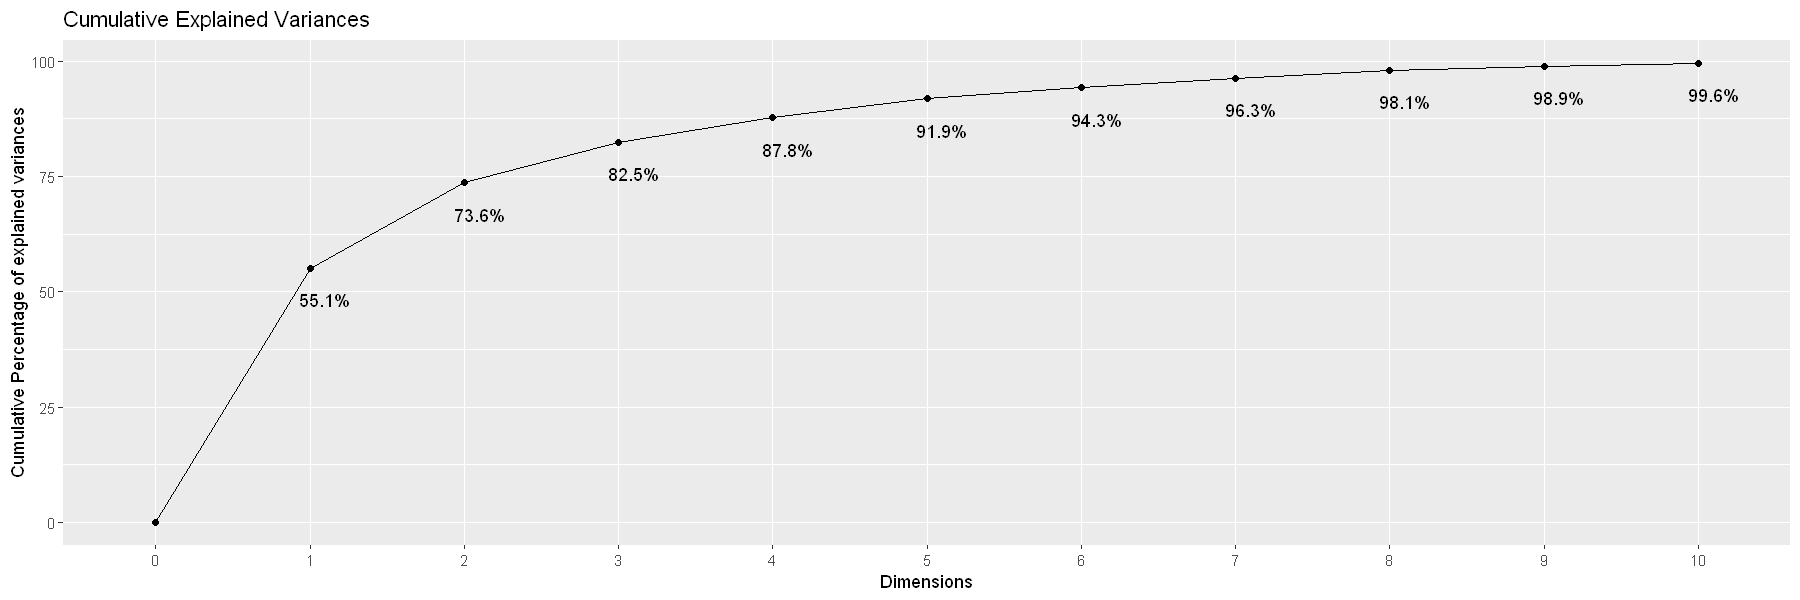

In [8]:
# resPC contains also the scree plot{scree.plot}, cumulative variance explained {CV.plot}, 
# the variables contribution of each component {contribCorr.plot()} and the quality of those 
# contributions {cos2Corr.plot()}.
options(repr.plot.width = 15, repr.plot.height = 5)
resPC$CV.plot

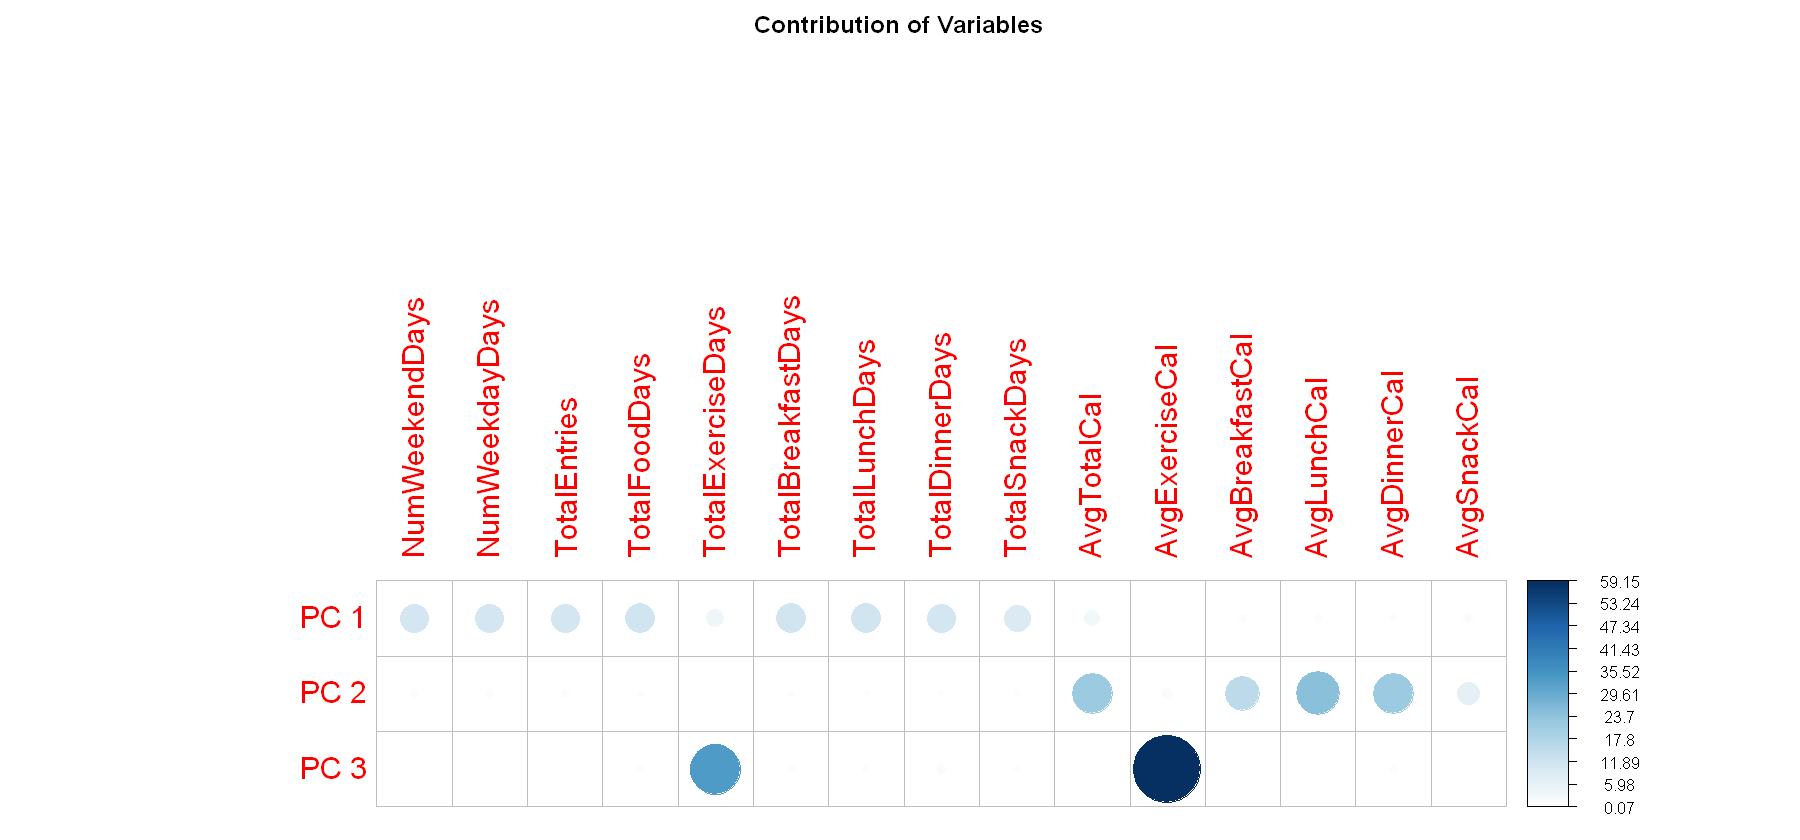

In [9]:
options(repr.plot.width = 15, repr.plot.height = 7)
resPC$contribCorr.plot(1.5) # to get numbers use resPC$contribCorrNum.plot()

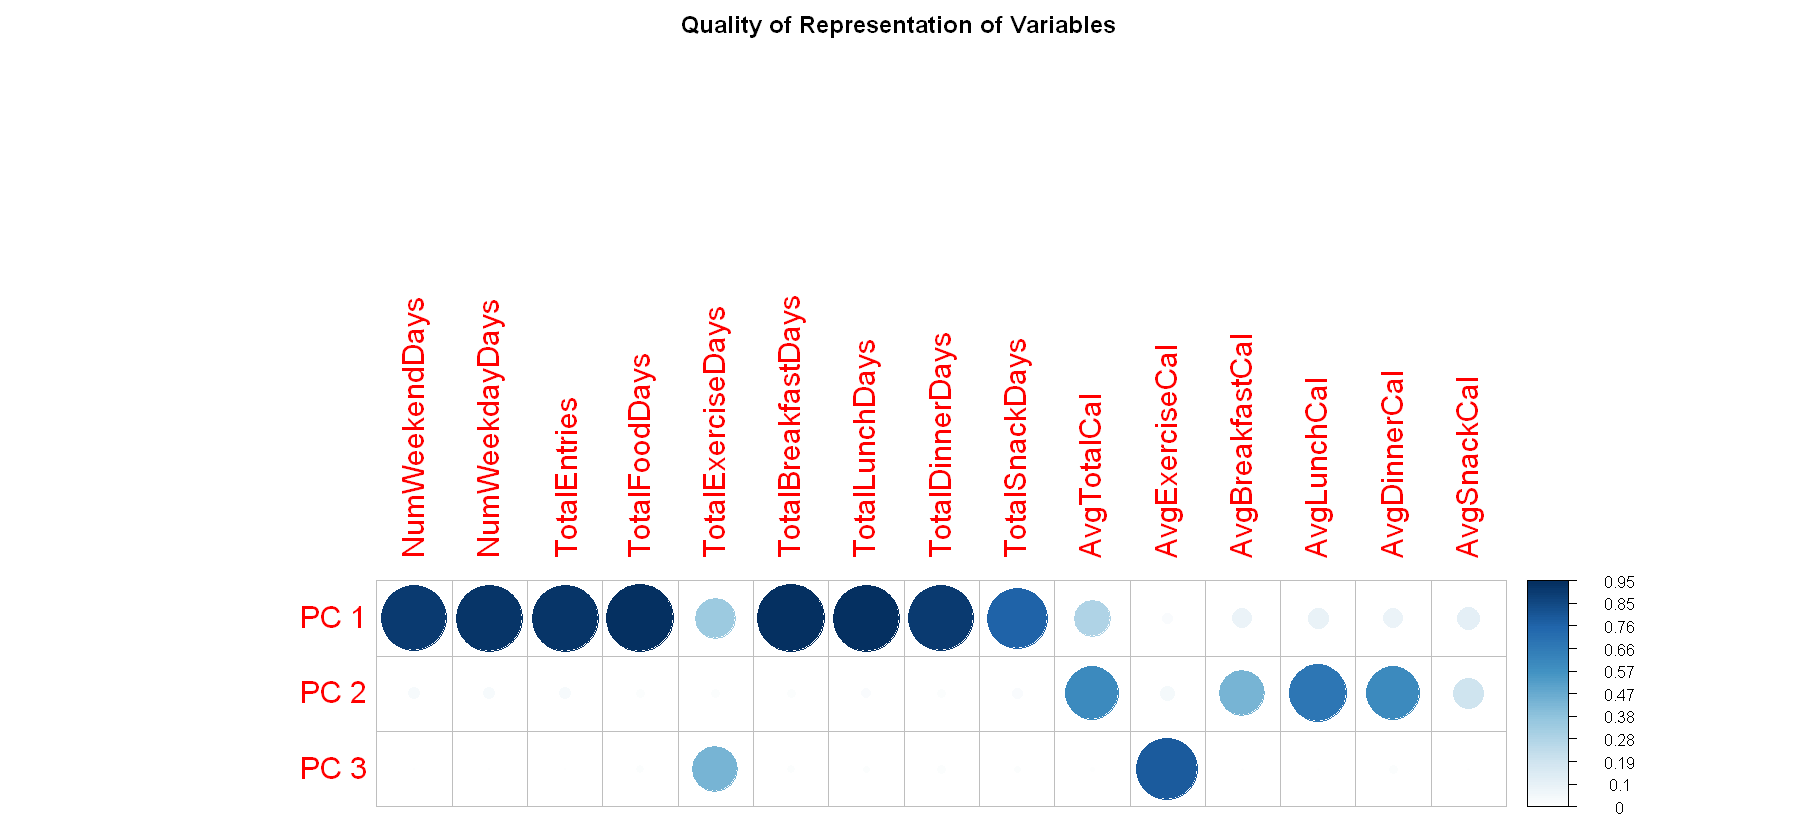

In [10]:
options(repr.plot.width = 15, repr.plot.height = 7)
resPC$cos2Corr.plot(1.5) # to get numbers use resPC$cos2CorrNum.plot()

---
## Analysis

The first step of the mediation analysis is to establish if our candidates variables are mediators or not.    
**To analyze the mediation we observe the following flowchart:**

![alt text](images/Mediation_flowchart.svg "Mediation Analysis flowchart")

**We first estimated two linear regressions for both the mediator and the outcome. We used also a permutation test to assess any associations with respect to our samples.**

**Clean the data:** *remove NA*

In [11]:
dat <- na.omit(dat)

---
### Relationship association assessment

We will consider the following assumptions:

* App usage and Number of self-weighing are casually unrelated mediators.
* Observed confounder is : age. 

#### **Regression of weight loss on the treatment.**

In [12]:
# Outcome model with confounders
out.fit <- lm(WeightLoss12Month ~ Treatment + Age, data = dat)
#  out.fit <- lm(WeightLoss12Month ~ Treatment + Age + Gender + logInitialWeight , data = dat)
summary(out.fit)


Call:
lm(formula = WeightLoss12Month ~ Treatment + Age, data = dat)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.164341 -0.029560 -0.004966  0.032544  0.210613 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.0417484  0.0245211  -1.703  0.09110 . 
Treatment    0.0315668  0.0102142   3.090  0.00246 **
Age          0.0012699  0.0006829   1.860  0.06524 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05657 on 127 degrees of freedom
Multiple R-squared:  0.1095,	Adjusted R-squared:  0.09552 
F-statistic: 7.812 on 2 and 127 DF,  p-value: 0.0006315


#### **Permutation test: Weight loss ~ treatment assignment**

The mean weight loss for intervention is: 0.0366197 
The mean weight loss for no intervention is: 0.001591016 
The absolute t-test statistic is:  3.450882 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 6e-04 .


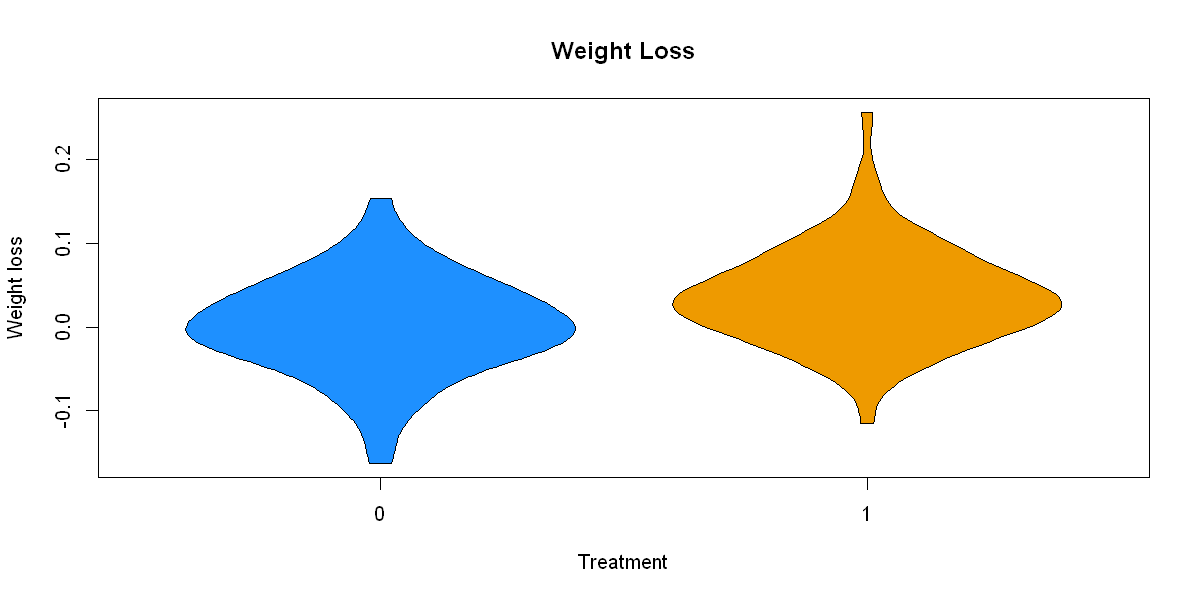

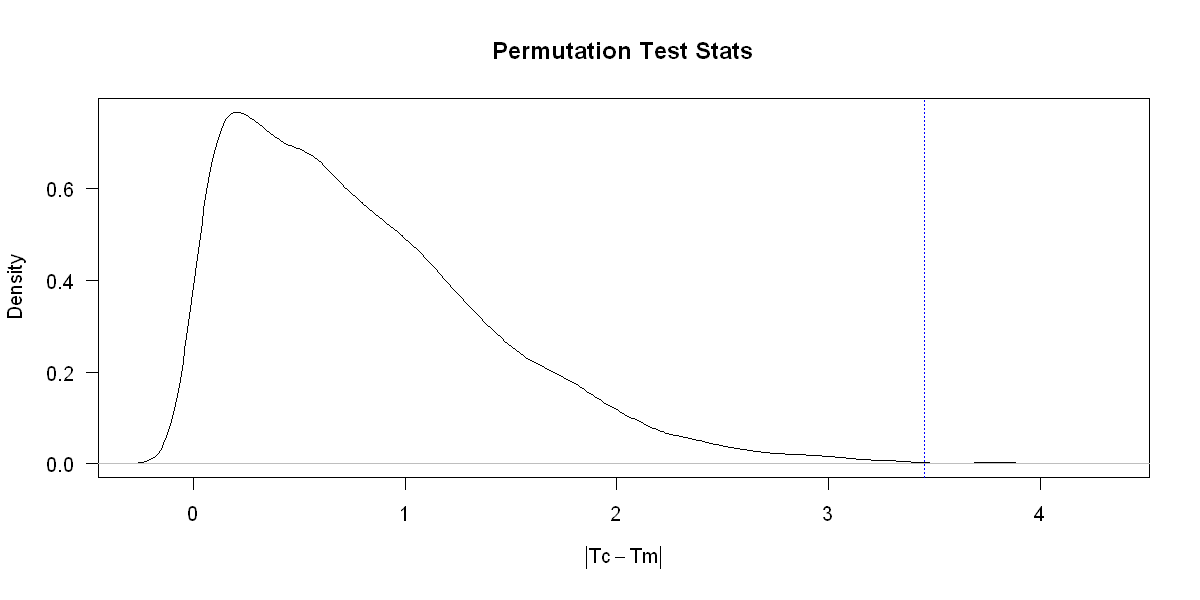

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5)
getPermut(dat$WeightLoss12Month, dat$Treatment, P = 10000)

***We confirmed that the treatment has a statistically significant predictive capability on weight loss outcome.***

#### **Regression of App-usage (*i.e.*, PC1 ) on the treatment.**

In [14]:
# Outcome model with confounders
out.fit <- lm(App1 ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = App1 ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4575 -1.4052 -0.1663  1.5675  6.4061 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.26007    0.94555  -2.390   0.0183 *  
Treatment    3.68261    0.39386   9.350 3.94e-16 ***
Age          0.02711    0.02633   1.029   0.3052    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.181 on 127 degrees of freedom
Multiple R-squared:  0.4283,	Adjusted R-squared:  0.4193 
F-statistic: 47.58 on 2 and 127 DF,  p-value: 3.797e-16


#### **Permutation test: App-usage ~ treatment assignment**

The mean weight loss for intervention is: 2.421557 
The mean weight loss for no intervention is: -1.334952 
The absolute t-test statistic is:  10.18506 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0 .


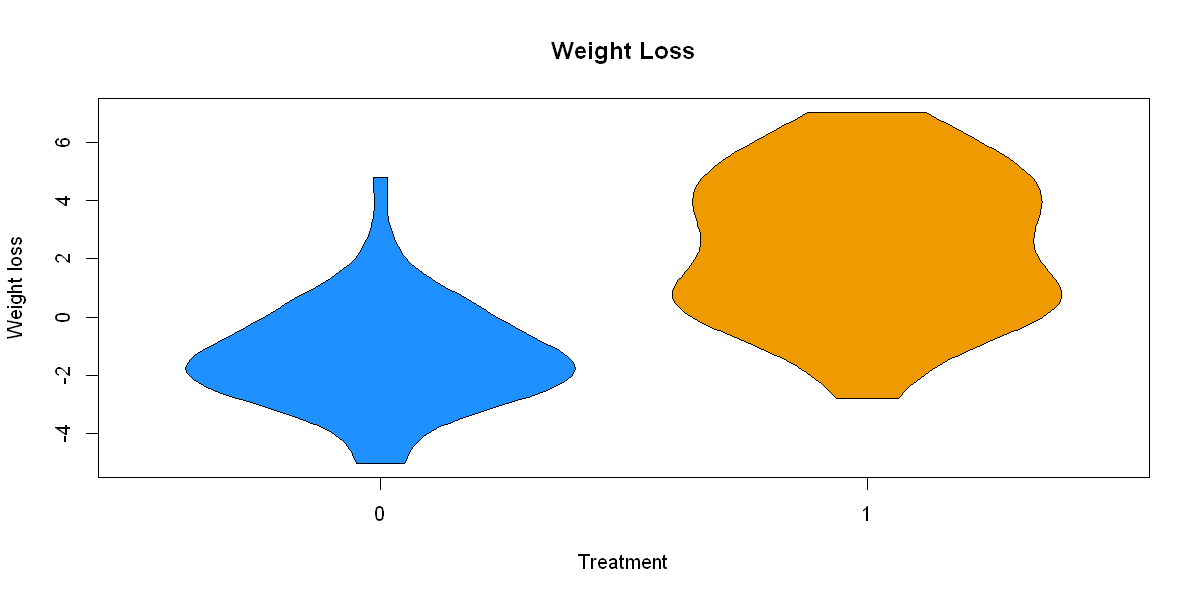

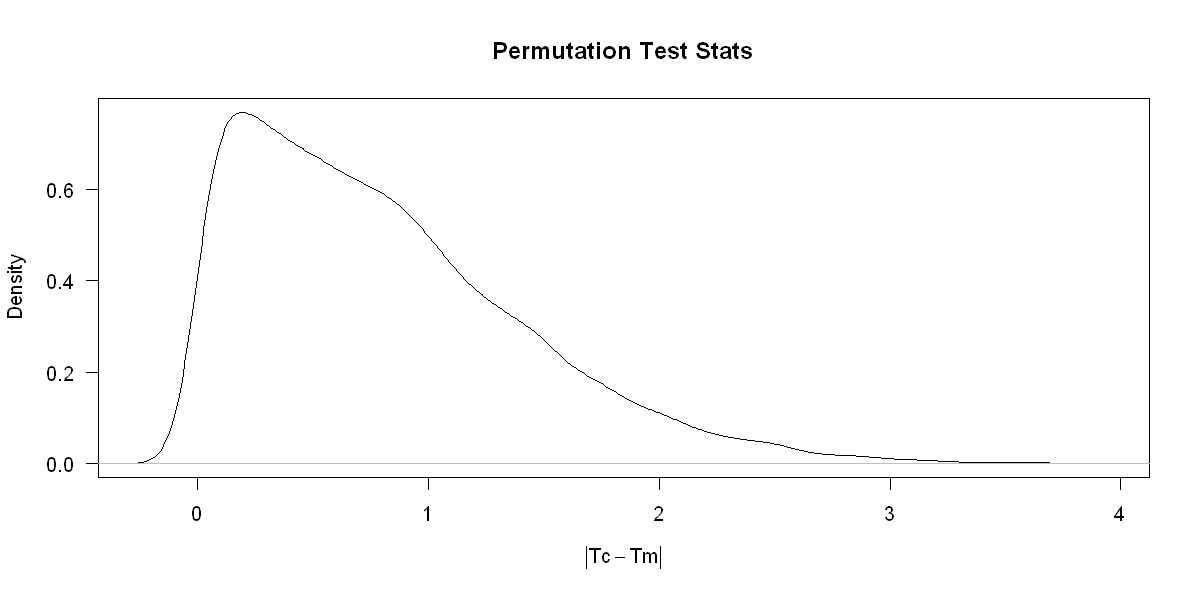

In [15]:
getPermut(dat$App1, dat$Treatment, P = 10000)

#### **Regression of App-calories (*i.e.*, PC2 ) on the treatment.**

In [16]:
# Outcome model with confounders
out.fit <- lm(App2 ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = App2 ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6857 -0.9653  0.0702  0.7541  5.6868 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.825825   0.664382  -1.243  0.21616   
Treatment    0.911984   0.276746   3.295  0.00127 **
Age          0.007453   0.018502   0.403  0.68774   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.533 on 127 degrees of freedom
Multiple R-squared:  0.08568,	Adjusted R-squared:  0.07128 
F-statistic:  5.95 on 2 and 127 DF,  p-value: 0.003386


#### **Permutation test: App-calories ~ treatment assignment**

The mean weight loss for intervention is: 0.3608357 
The mean weight loss for no intervention is: -0.5714661 
The absolute t-test statistic is:  3.25049 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0.0014 .


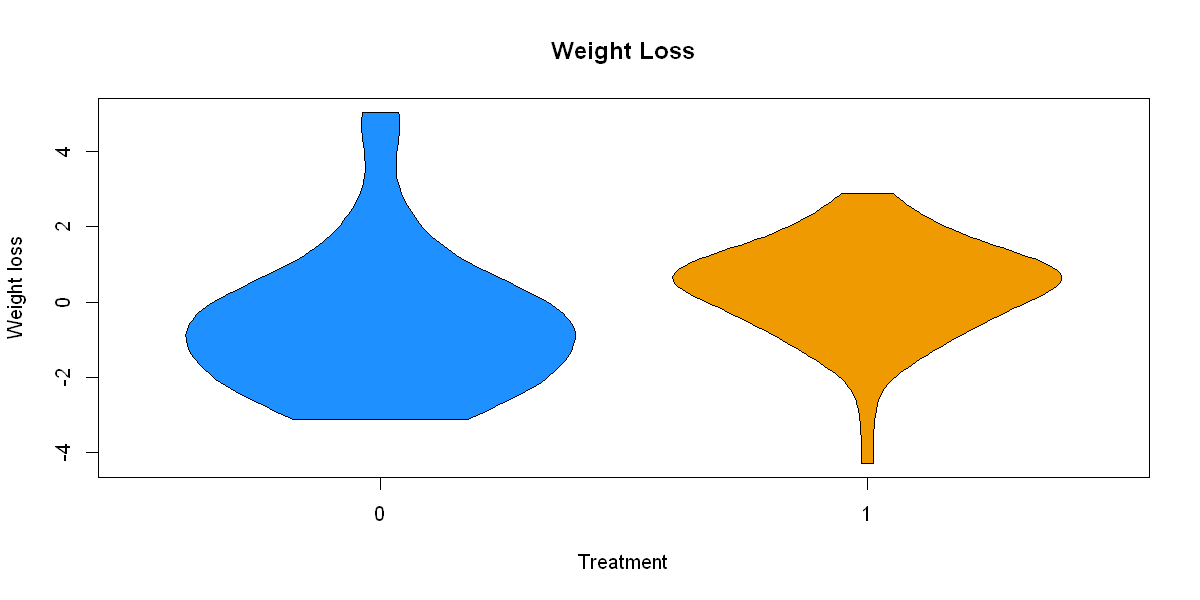

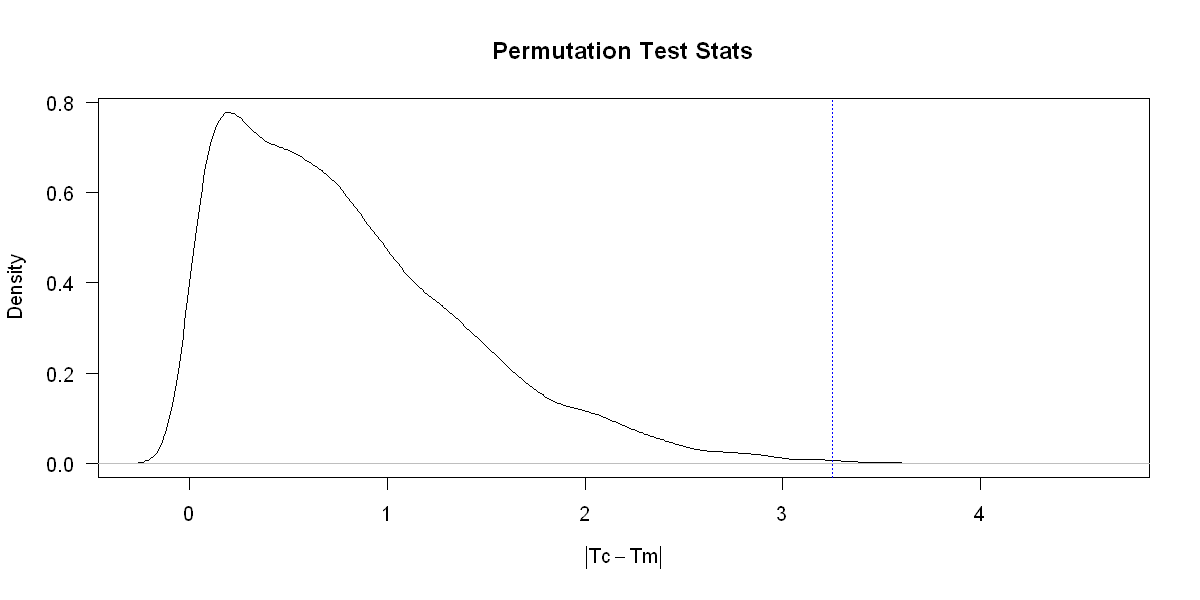

In [17]:
getPermut(dat$App2, dat$Treatment, P = 10000)

#### **Regression of App-exercise (*i.e.*, PC3 ) on the treatment.**

In [18]:
# Outcome model with confounders
out.fit <- lm(App3 ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = App3 ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0998 -1.0230  0.1562  0.8603  4.2203 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.94397    0.53004   1.781   0.0773 .
Treatment    0.05021    0.22079   0.227   0.8205  
Age         -0.02968    0.01476  -2.011   0.0464 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.223 on 127 degrees of freedom
Multiple R-squared:  0.03101,	Adjusted R-squared:  0.01575 
F-statistic: 2.032 on 2 and 127 DF,  p-value: 0.1353


#### **Permutation test: App-exercise ~ treatment assignment**

The mean weight loss for intervention is: -0.09979518 
The mean weight loss for no intervention is: -0.06907967 
The absolute t-test statistic is:  0.146207 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0.8777 .


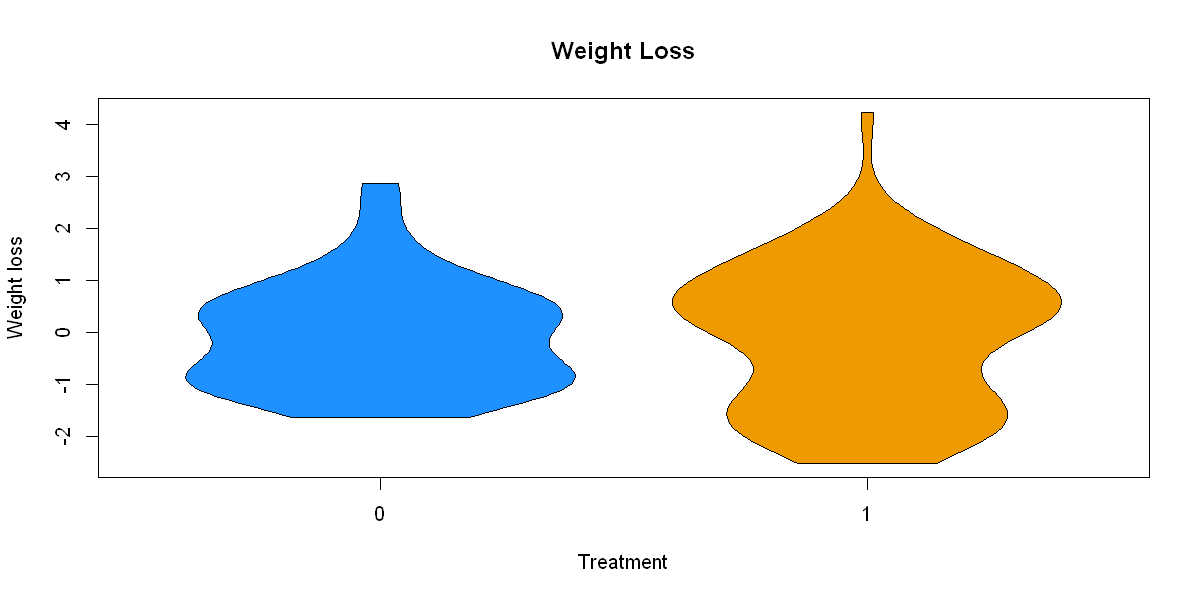

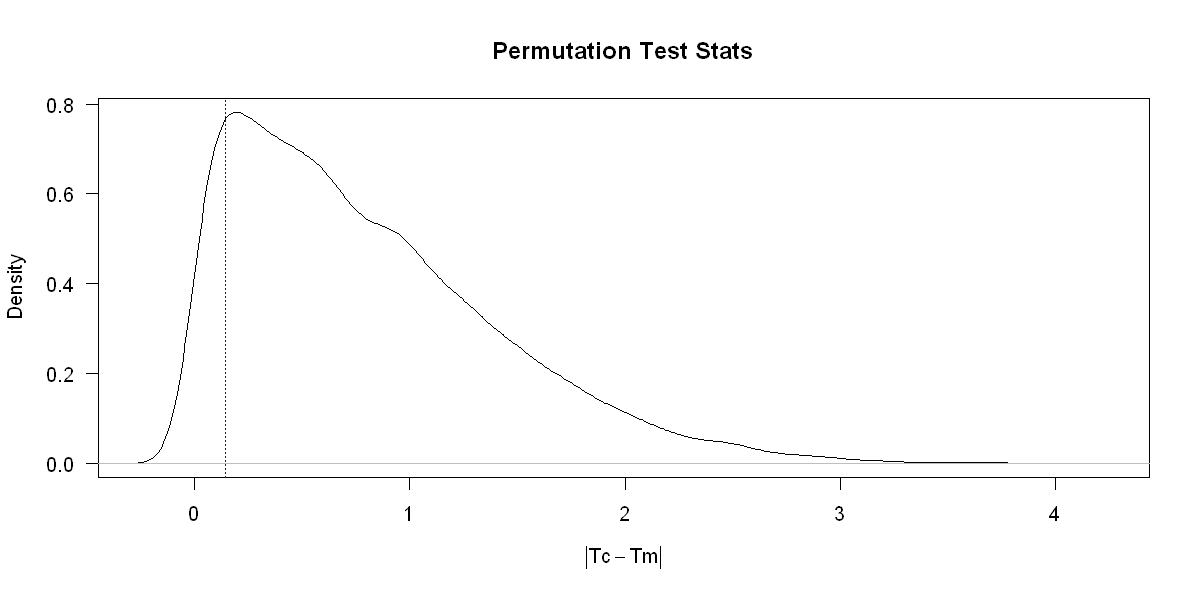

In [19]:
getPermut(dat$App3, dat$Treatment, P = 10000)

#### **Regression of Self-weight on the treatment.**

In [20]:
# Outcome model with confounders
out.fit <- lm(NumWeigh ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = NumWeigh ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-208.57  -60.38  -10.57   56.17  180.53 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 119.7862    35.6641   3.359  0.00103 ** 
Treatment    77.7137    14.8558   5.231 6.75e-07 ***
Age           0.3909     0.9932   0.394  0.69453    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 82.28 on 127 degrees of freedom
Multiple R-squared:  0.1872,	Adjusted R-squared:  0.1744 
F-statistic: 14.62 on 2 and 127 DF,  p-value: 1.929e-06


#### **Permutation test: Self-weight ~ treatment assignment**

The mean weight loss for intervention is: 211.9067 
The mean weight loss for no intervention is: 133.1273 
The absolute t-test statistic is:  5.383558 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0 .


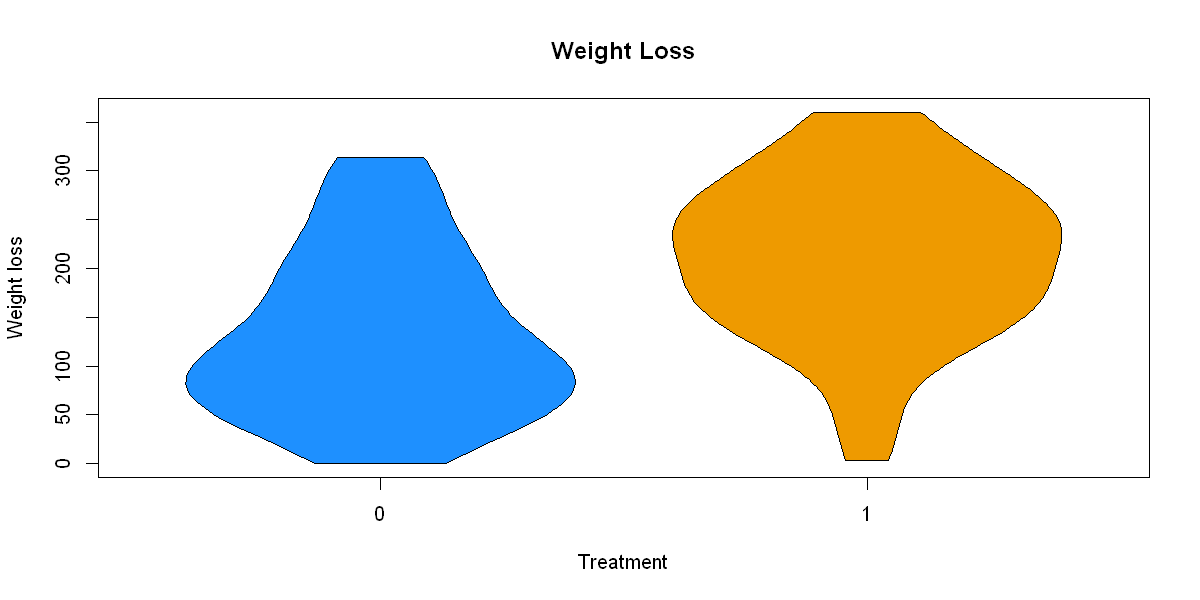

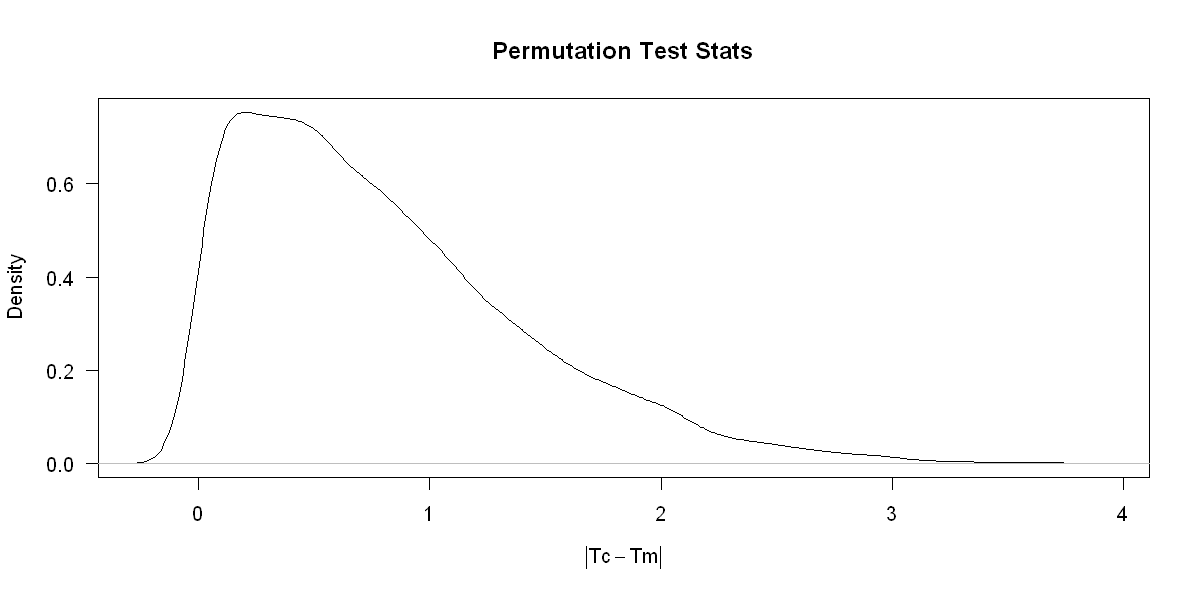

In [21]:
getPermut(dat$NumWeigh, dat$Treatment, P = 10000)

#### **Regression of 4-month weight loss on the treatment.**

In [22]:
# Outcome model with confounders
out.fit <- lm(WeightLoss4Month ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = WeightLoss4Month ~ Treatment + Age, data = dat)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.072002 -0.024023 -0.005307  0.015075  0.167338 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0019456  0.0168705  -0.115    0.908    
Treatment    0.0399147  0.0070273   5.680 8.73e-08 ***
Age          0.0003358  0.0004698   0.715    0.476    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03892 on 127 degrees of freedom
Multiple R-squared:  0.2181,	Adjusted R-squared:  0.2058 
F-statistic: 17.71 on 2 and 127 DF,  p-value: 1.638e-07


#### **Permutation test: 4-month weight loss ~ treatment assignment**

The mean weight loss for intervention is: 0.05034562 
The mean weight loss for no intervention is: 0.009515432 
The absolute t-test statistic is:  6.082718 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0 .


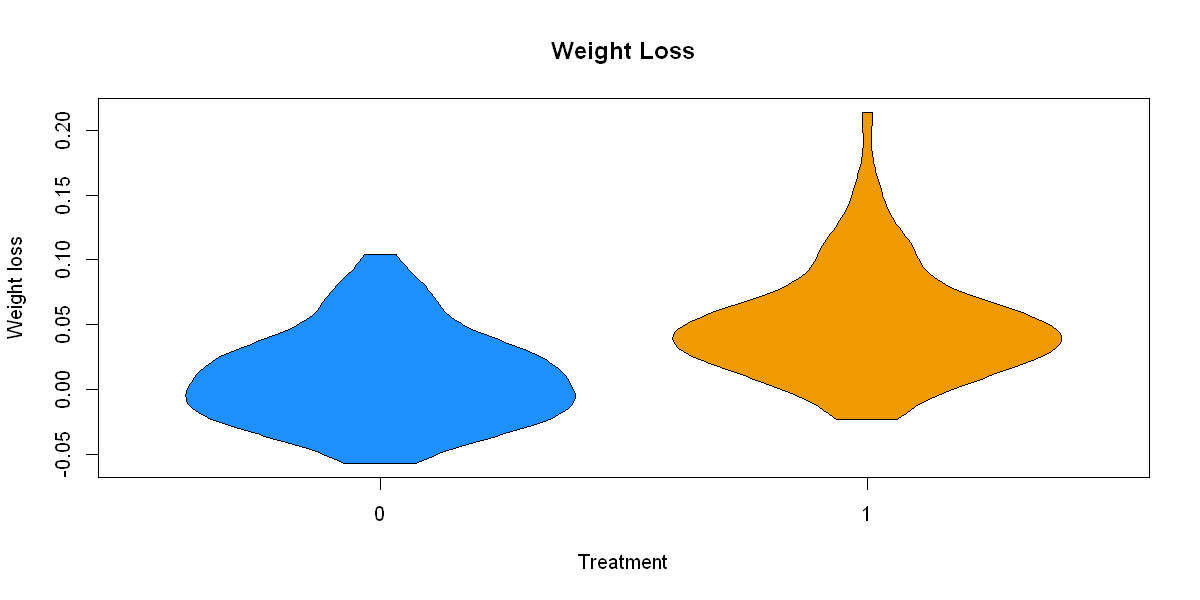

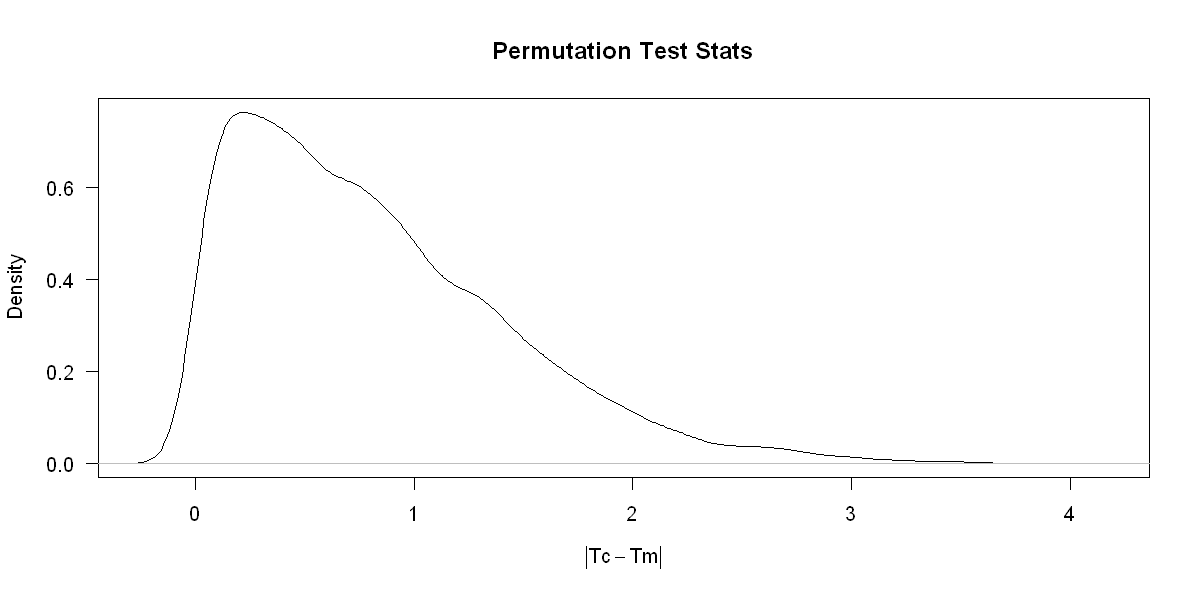

In [23]:
getPermut(dat$WeightLoss4Month, dat$Treatment, P = 10000)

***We confirmed that the treatment has a statistically significant predictive capability on all potential mediators except for the app-exercise. Since app-usage variable (i.e., PC1) explained more than 55% of the variance, we considered only app-usage, self-weight and the 4-month weight loss variables for the mediation analysis for the 12 month-weight loss.***

---
## Mediation

**Our function `getMediationTable` to estimate the Average Causal Mediation Effect (ACME) and the Average Direct Effect (ADE) associated with each mediator is based on  the `mediation` library.**

In [26]:
numFile <- 2
rslts <- getMediationTable(dat, numFile, myRobustSE = TRUE, numSims = 10000, confLvl = 0.90) 


### **Mediation Results** 


In [35]:
rslts$med.tbl %>% round(5)%>%
  kable("html") %>% 
  column_spec(c(1), bold = T, color = "black") %>%
  column_spec(c(2, 5, 8), bold = T, color = "steelblue") %>%
  column_spec(c(3, 4, 6, 7, 9, 10), bold = T, color = "sienna") %>%
  column_spec(c(11), bold = T, color = "black")%>%
  as.character() %>%
  display_html()

,Total Effect,Lower CI,Upper CI,ADE,Lower CI,Upper CI,ACME,Lower CI,Upper CI,Prop. Mediated
App-usage,0.03153,0.01488,0.04830,0.01613,-0.00693,0.03857,0.01540,-0.00032,0.03117,0.48885
Self-weight,0.03146,0.01431,0.04893,0.01649,0.00084,0.03194,0.01497,0.00611,0.02508,0.47348
4 Months Weight Loss,0.03157,0.01473,0.04884,0.00182,-0.01312,0.01682,0.02975,0.01888,0.04212,0.94316


---
## Sensitivity Analysis

In [37]:
# Sensitivity for the 4-month weight loss
sens4Month.out <- medsens(rslts$med.rslts$med4Month.out, rho.by = 0.01, effect.type = "indirect", sims = 10000)

In [36]:
# Sensitivity for the app-usage
sensApp.out <- medsens(rslts$med.rslts$medApp.out, rho.by = 0.01, effect.type = "indirect", sims = 10000)
# Sensitivity for the self-weight
sensNumW.out <- medsens(rslts$med.rslts$medNumW.out, rho.by = 0.01, effect.type = "indirect", sims = 10000)

### 4-month weight loss

#### Results

In [39]:
summary(sens4Month.out)


Mediation Sensitivity Analysis for Average Causal Mediation Effect

Sensitivity Region

       Rho    ACME 90% CI Lower 90% CI Upper R^2_M*R^2_Y* R^2_M~R^2_Y~
 [1,] 0.41  0.0076      -0.0001       0.0152       0.1681       0.0859
 [2,] 0.42  0.0069      -0.0007       0.0145       0.1764       0.0902
 [3,] 0.43  0.0062      -0.0013       0.0138       0.1849       0.0945
 [4,] 0.44  0.0056      -0.0019       0.0131       0.1936       0.0990
 [5,] 0.45  0.0049      -0.0026       0.0123       0.2025       0.1035
 [6,] 0.46  0.0042      -0.0033       0.0116       0.2116       0.1082
 [7,] 0.47  0.0034      -0.0039       0.0108       0.2209       0.1129
 [8,] 0.48  0.0027      -0.0046       0.0101       0.2304       0.1178
 [9,] 0.49  0.0020      -0.0054       0.0093       0.2401       0.1227
[10,] 0.50  0.0012      -0.0061       0.0086       0.2500       0.1278
[11,] 0.51  0.0004      -0.0069       0.0078       0.2601       0.1329
[12,] 0.52 -0.0003      -0.0077       0.0070       0.2704  

#### Sensitivity with respect to error correlation

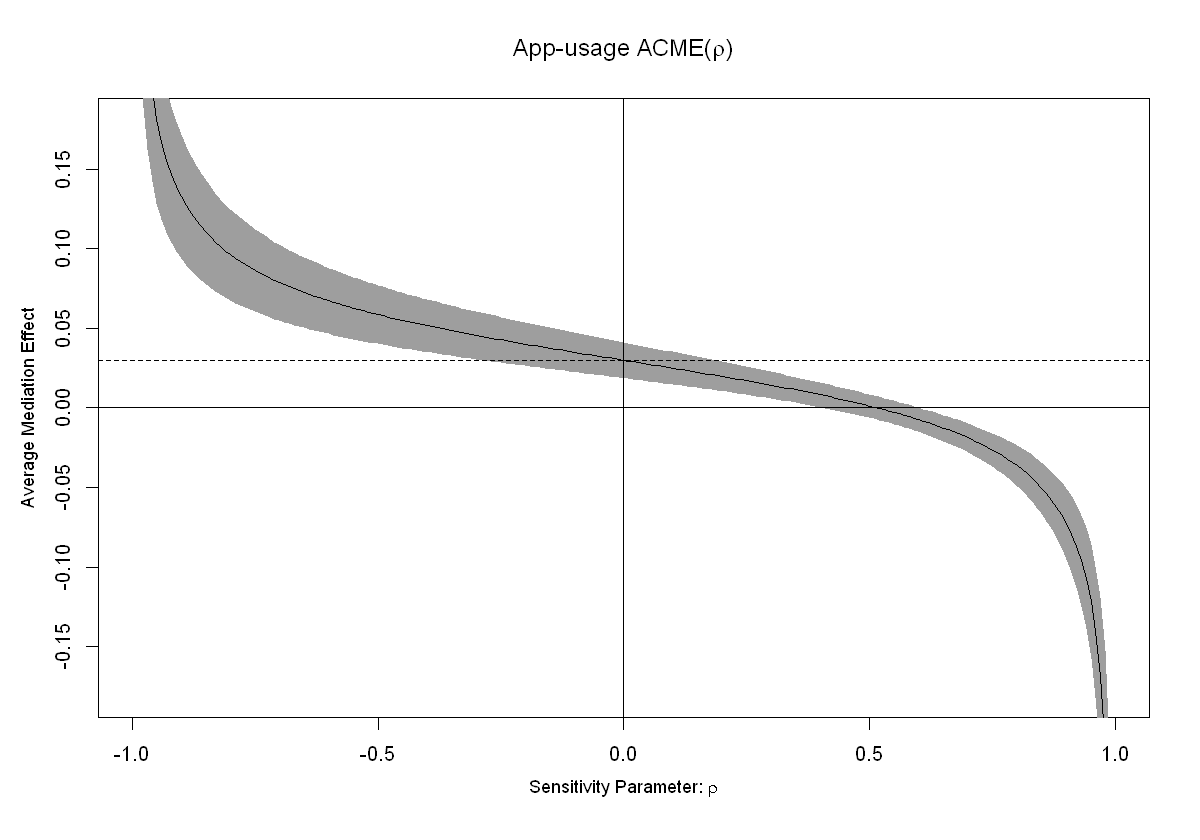

In [40]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot(sens4Month.out,  ylim = c(-0.18, 0.18), main  =  expression(paste("App-usage ACME(", rho, ")")))

The above figure shows the estimated true values of ACMEs as a function of the sensitivity parameter $\rho$. The parameter $\rho$
expresses the correlation between the error terms in the mediator and the outcome models. The solid thick line and its shaded area represent the ACME's point estimates and their 90% confidence intervals, respectively.    
According to this analysis, the ACME is estimated to be negative when  $\rho$ is larger than 0.52, and the ACME is statistically indistinguishable from zero at the 90% level when the parameter $\rho$ is larger than 0.41.

#### Sensitivity with respect to proportion of variance explained

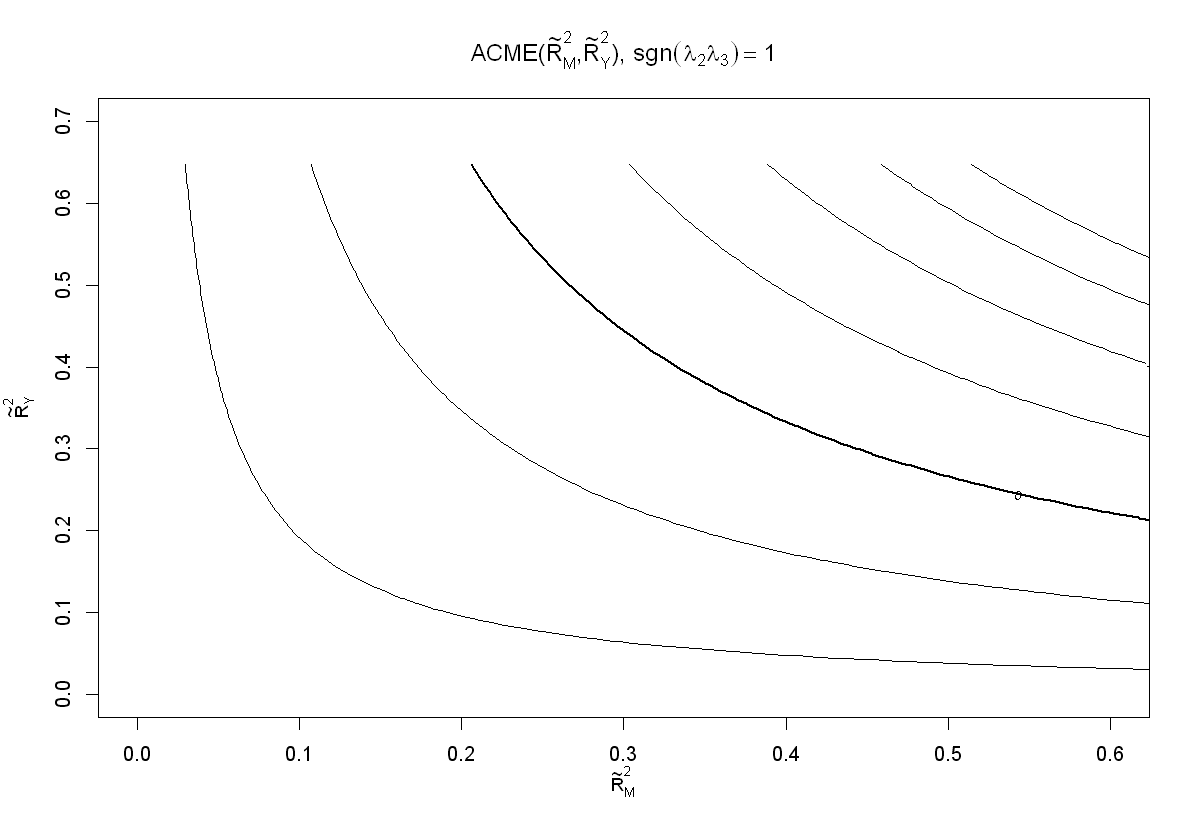

In [41]:
plot(sens4Month.out, sens.par = "R2", r.type = "total", sign.prod = "positive",
     xlim = c(-0.0, 0.6), ylim = c(-0.0, 0.7))

In the sensitivity analyses plot above, the ACME estimates are plotted against $\tilde{R}^2_Y \tilde{R}^2_M$, the proportions of the total variance in the outcome and mediator variables, respectively, that would be explained by a hypothetical unobserved pretreatment confounder.
In terms of the coefficient of determination parameters, the product of $\tilde{R}^2_M$ and $\tilde{R}^2_Y$ must be at least as large
as 0.0518, implying that an unobserved pretreatment confounder must explain 20% of the variation in the participants’ 4-month weight loss and 69.1% of the variation in their weight loss, for example.

### App-usage

#### Results

In [43]:
summary(sensApp.out)


Mediation Sensitivity Analysis for Average Causal Mediation Effect

Sensitivity Region

       Rho    ACME 90% CI Lower 90% CI Upper R^2_M*R^2_Y* R^2_M~R^2_Y~
 [1,] 0.01  0.0146      -0.0003       0.0295       0.0001       0.0000
 [2,] 0.02  0.0137      -0.0012       0.0286       0.0004       0.0002
 [3,] 0.03  0.0127      -0.0021       0.0276       0.0009       0.0004
 [4,] 0.04  0.0118      -0.0031       0.0266       0.0016       0.0008
 [5,] 0.05  0.0108      -0.0040       0.0257       0.0025       0.0012
 [6,] 0.06  0.0099      -0.0049       0.0247       0.0036       0.0018
 [7,] 0.07  0.0089      -0.0059       0.0238       0.0049       0.0024
 [8,] 0.08  0.0080      -0.0068       0.0228       0.0064       0.0032
 [9,] 0.09  0.0070      -0.0077       0.0218       0.0081       0.0040
[10,] 0.10  0.0061      -0.0087       0.0209       0.0100       0.0050
[11,] 0.11  0.0051      -0.0096       0.0199       0.0121       0.0060
[12,] 0.12  0.0042      -0.0106       0.0189       0.0144  

#### Sensitivity with respect to error correlation

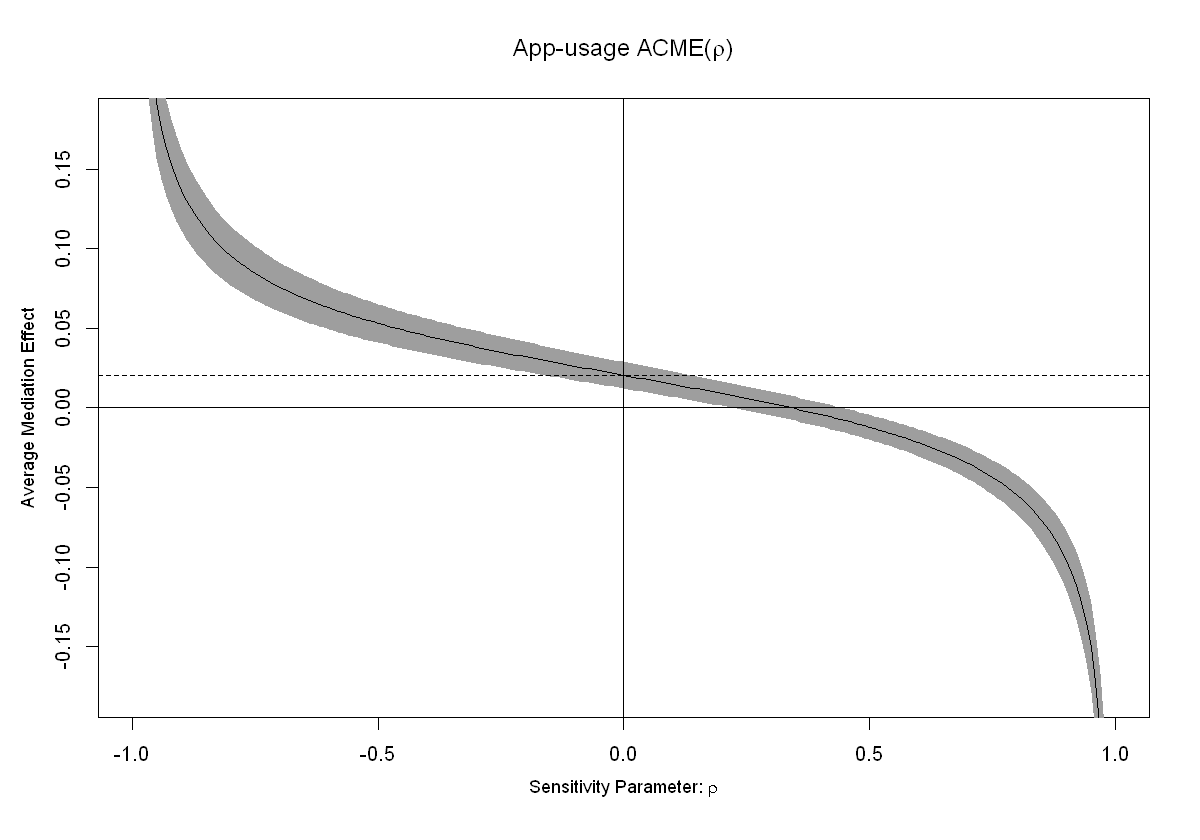

In [55]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot(sensApp.out,  ylim = c(-0.18, 0.18), main  =  expression(paste("App-usage ACME(", rho, ")")))

The above figure shows the estimated true values of ACMEs as a function of the sensitivity parameter $\rho$. The parameter $\rho$
expresses the correlation between the error terms in the mediator and the outcome models. The solid thick line and its shaded area represent the ACME's point estimates and their 90% confidence intervals, respectively.    
According to this analysis, the ACME is estimated to be negative when  $\rho$ is larger than 0.16, and the ACME is statistically indistinguishable from zero at the 90% level when the parameter $\rho$ is larger than 0.01.

#### Sensitivity with respect to proportion of variance explained

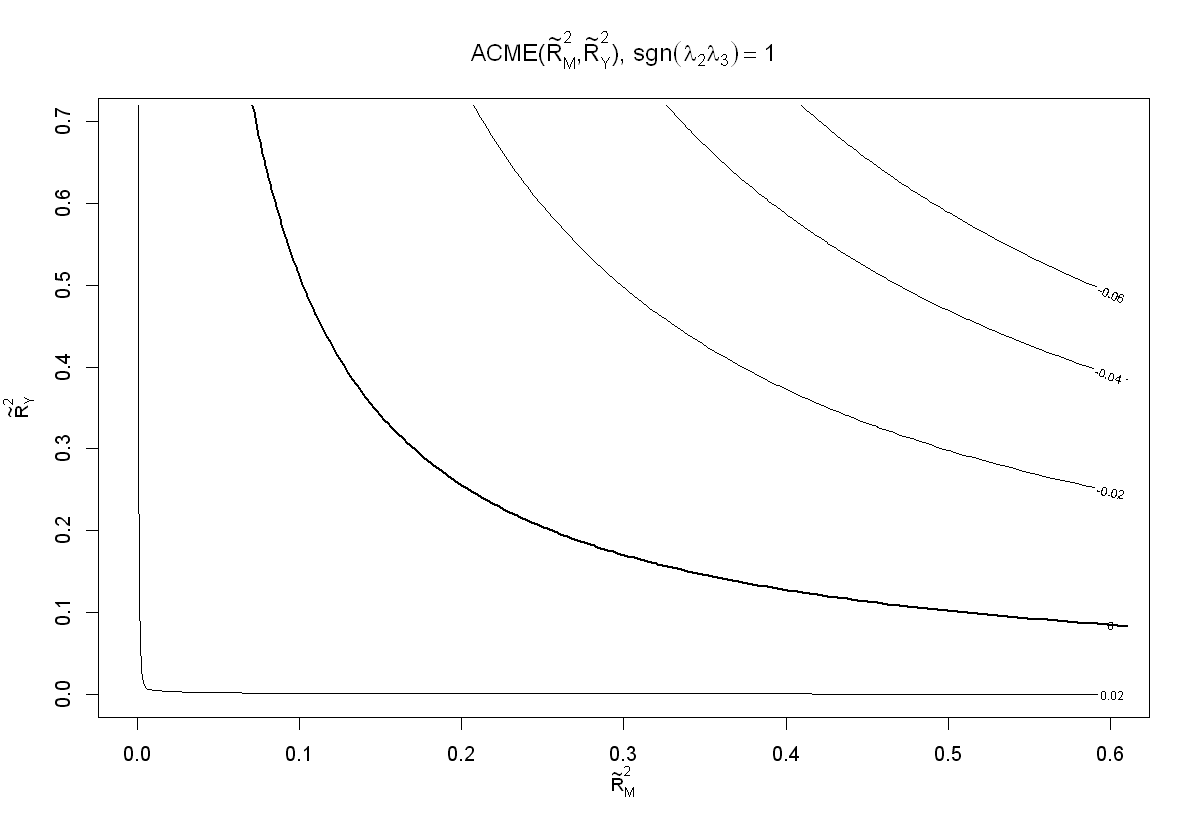

In [50]:
plot(sensApp.out, sens.par = "R2", r.type = "total", sign.prod = "positive",
     xlim = c(-0.0, 0.6), ylim = c(-0.0, 0.7))

In the sensitivity analyses plot above, the ACME estimates are plotted against $\tilde{R}^2_Y \tilde{R}^2_M$, the proportions of the total variance in the outcome and mediator variables, respectively, that would be explained by a hypothetical unobserved pretreatment confounder.
In terms of the coefficient of determination parameters, the product of $\tilde{R}^2_M$ and $\tilde{R}^2_Y$ must be at least as large
as 0.0127, implying that an unobserved pretreatment confounder must explain 20% of the variation in the participants’ app-usage and 6.3% of the variation in their weight loss, for example.


### Self-weight

#### Results

In [47]:
summary(sensNumW.out)


Mediation Sensitivity Analysis for Average Causal Mediation Effect

Sensitivity Region

       Rho    ACME 90% CI Lower 90% CI Upper R^2_M*R^2_Y* R^2_M~R^2_Y~
 [1,] 0.13  0.0082       0.0000       0.0165       0.0169       0.0113
 [2,] 0.14  0.0077      -0.0005       0.0159       0.0196       0.0131
 [3,] 0.15  0.0072      -0.0010       0.0153       0.0225       0.0150
 [4,] 0.16  0.0066      -0.0015       0.0148       0.0256       0.0171
 [5,] 0.17  0.0061      -0.0020       0.0142       0.0289       0.0193
 [6,] 0.18  0.0056      -0.0025       0.0136       0.0324       0.0216
 [7,] 0.19  0.0050      -0.0030       0.0130       0.0361       0.0241
 [8,] 0.20  0.0045      -0.0035       0.0125       0.0400       0.0267
 [9,] 0.21  0.0039      -0.0040       0.0119       0.0441       0.0294
[10,] 0.22  0.0034      -0.0045       0.0113       0.0484       0.0323
[11,] 0.23  0.0028      -0.0051       0.0107       0.0529       0.0353
[12,] 0.24  0.0023      -0.0056       0.0102       0.0576  

#### Sensitivity with respect to error correlation

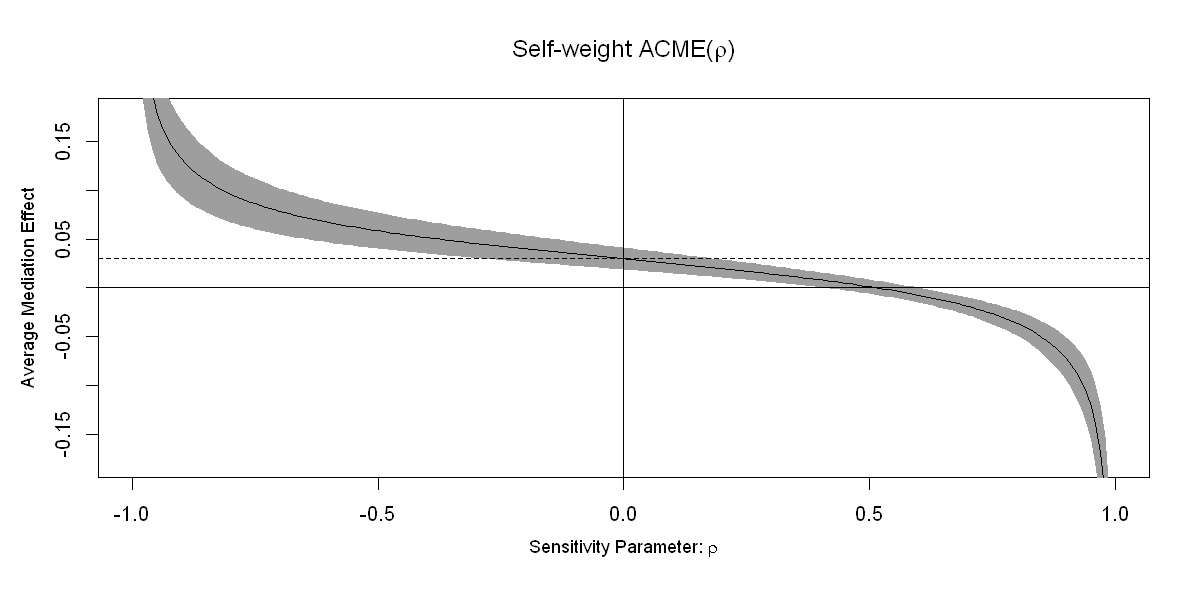

In [36]:
plot(sensNumW.out,  ylim = c(-0.18, 0.18), main  =  expression(paste("Self-weight ACME(", rho, ")")))

The above figure shows the estimated true values of ACMEs as a function of the sensitivity parameter $\rho$. The parameter $\rho$
expresses the correlation between the error terms in the mediator and the outcome models. The solid thick line and its shaded area represent the ACME's point estimates and their 90% confidence intervals, respectively.    
According to this analysis, the ACME is estimated to be negative when  $\rho$ is larger than 0.28, and the ACME is statistically indistinguishable from zero at the 90% level when the parameter $\rho$ is larger than 0.13.

### Sensitivity with respect to proportion of variance explained

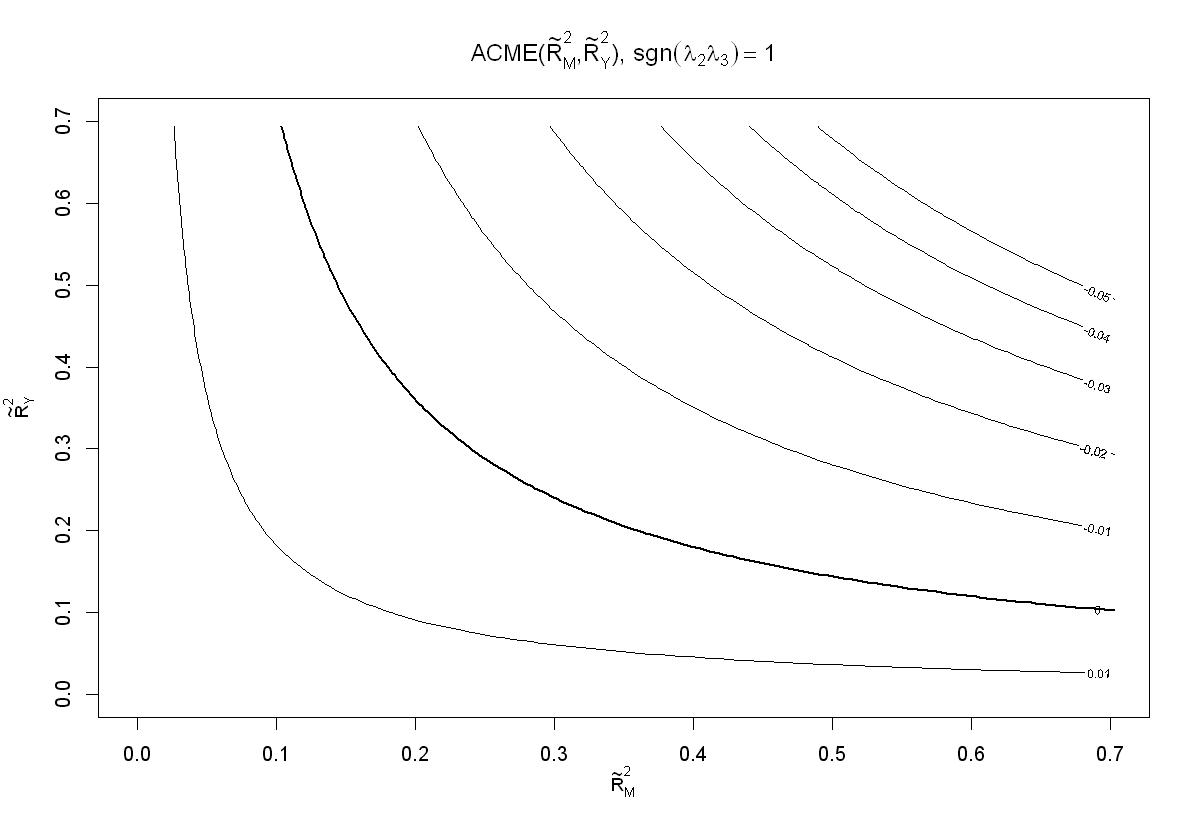

In [63]:
plot(sensNumW.out, sens.par = "R2", r.type = "total", sign.prod = "positive",
     xlim = c(-0.0, 0.7), ylim = c(-0.0, 0.7))

In the sensitivity analyses plot above, the ACME estimates are plotted against $\tilde{R}^2_Y \tilde{R}^2_M$, the proportions of the total variance in the outcome and mediator variables, respectively, that would be explained by a hypothetical unobserved pretreatment confounder.
In terms of the coefficient of determination parameters, the product of $\tilde{R}^2_M$ and $\tilde{R}^2_Y$ must be at least as large
as 0.0523, implying that an unobserved pretreatment confounder must explain 20% of the variation in the participants’ app-usage and 26.1% of the variation in their weight loss, for example.

## Conclusion

Overall, the results suggest that under the assumption of independence between mechanisms, the causal mediation effects are positive and not significant for the app-usage and it is significant for the self weight and for the 4-month weight loss mediator, and the estimates for the 4-month weight loss showed robustness to the
possible unobserved pretreatment mediator–outcome confounding to varying degrees. However, the estimates for app-usage are not robust to the
possible unobserved pretreatment mediator–outcome confounding to varying degrees.